# microfiltR
# Processing and filtering marker gene datasets

Here, we'll walk through some filtering strategies applicable to compositional marker gene studies. We will employ several custom R functions designed to manipulate phyloseq-class datasets that aid in the processing, filtering, and reproducability of marker gene studies. We apply this workflow to a large 16S community dataset generated from three Illumina MiSeq runs, though these strategies should be widely useful to any marker gene and easily scalable to large datasets with thousands of taxa and samples. _For reference, this entire notebook can be run in about 30 seconds on a 13" 2013 Macbook Pro._<br>
<br>
Briefly, the aims of this vignette and associated functions are to:<br>
1. Estimate and apply dataset-specific filtering parameters.<br>
2. Provide a set of robust and highly reproducible processing, filtering, and exporting functions for marker gene studies.<br>
3. Faciltate transparency and reproducability of marker gene data analysis, regardless of user skill level.<br>

<div class="alert alert-block alert-info">
<b>A preface on filtering:</b> Filtering is an <i>essential</i> step in the analyis of marker gene datasets. This workflow uses a two-pronged approach (within sample and across sample) to filtering contaminants from read datasets. That is, we attempt to remove two types of contamination: <br>
<br>
1. Real biological sequences that have cross contaminated unassociated samples. <br>
<br>
2. Exogenous contaminants introduced during sample preparation. <br>
<br>
To achieve this, we first estimate and apply a <b>within-sample (WS)</b> threshold that taxa must exist above to remain in that sample. We estimate this threshold empirically by aligning amplicon sequence variant (ASV) nucleotide sequences to an external FASTA file of nucleotide sequences of each member of a positive control library, selecting the threshold that returns the appropriate alignment count. Next, we (optionally) remove control samples from the dataset and then apply several <b>across-sample (AS)</b> thresholds (relative abundance, prevalence, and/or coefficient of variation (CV)) to remove exogenous contaminants present as low abundance, stochastically represented, or invariant ASVs. 
</div>

<br>
<div class="alert alert-block alert-success">
<b>TIP:</b> Though this document follows a workflow for filtering out contaminant taxa from marker gene datasets, <b>microfilter</b>, <b>write.dataset</b>, and <b>write.dataset.biom can be used on any phyloseq-class dataset at any point, regardless of processing method, the number or presence of control samples, the marker gene sequenced, or if any filters have been applied.</b> 
</div>
***

## Jump to section:
[estimate.WSthreshold](#estimate.WSthreshold)<br>
[plot.threshold](#plot.threshold)<br>
[estimate.ASthreshold](#estimate.ASthreshold)<br>
[microfilter](#microfilter)<br>
[write.dataset](#write.dataset)


## Before we begin...
This workflow assumes that your sequencing project: 
-  has been converted into a __[phyloseq](https://joey711.github.io/phyloseq/)__ object.

and ideally:<br>
-  includes a mock community or other positive control of known composition. <br>
-  has been processed with __[dada2](https://benjjneb.github.io/dada2/index.html)__ (this is not necessary, but we leverage the output of dada2 to align control sequences and write filtered FASTA files).<br>
<br>
Now, let's load some required packages and begin!

In [1]:
library(phyloseq); packageVersion("phyloseq")

[1] ‘1.24.2’

In [2]:
suppressMessages(library(cowplot)); packageVersion("cowplot")

Warning message:
“package ‘cowplot’ was built under R version 3.5.2”Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

[1] ‘0.9.4’

In [3]:
suppressMessages(library(dplyr)); packageVersion("dplyr")

Warning message:
“package ‘dplyr’ was built under R version 3.5.2”

[1] ‘0.8.1’

In [4]:
library(ggplot2); packageVersion("ggplot2")
theme_set(theme_bw()) #gray is a bummer

[1] ‘3.1.1’

In [5]:
suppressMessages(library(tidyr)); packageVersion("tidyr")

Warning message:
“package ‘tidyr’ was built under R version 3.5.2”

[1] ‘0.8.3’

In [6]:
suppressMessages(library(ShortRead)); packageVersion("ShortRead")


[1] ‘1.38.0’

## Getting started
First, we'll need to source these functions into our R environment. 

In [7]:
source("/Users/bpb/Documents/GitHub/microfiltR/microfiltR_source_code.R")

Now, let's load the dataset and subset it to remove taxa not annotated at the Phylum level and identified as Chloroplast sequences.

In [8]:
#load the dataset
e3 <- readRDS(file = "/Users/bpb/Desktop/ECHO/Data/Combined_Run101218_Run101618/analysis/ECHO_2runs_Oct18.rds")

e3 %>%
  subset_taxa(Phylum != "NA" & 
                Phylum != "Cyanobacteria/Chloroplast") -> e3

table(tax_table(e3)[, "Phylum"], exclude = NULL)


              Acidobacteria              Actinobacteria 
                         43                         345 
            Armatimonadetes               Bacteroidetes 
                          1                         453 
   candidate_division_WPS-1 Candidatus_Saccharibacteria 
                          4                          16 
                 Chlamydiae                 Chloroflexi 
                          1                          18 
        Deinococcus-Thermus                  Firmicutes 
                         18                         861 
               Fusobacteria            Gemmatimonadetes 
                         50                           5 
                Nitrospirae               Parcubacteria 
                          1                           2 
             Planctomycetes              Proteobacteria 
                         13                         624 
               Spirochaetes               Synergistetes 
                          4   

For this vignette, we'll work with a subset of a recent study of vaginal swabs from a multinational African cohort. Let's take a look at the raw dataset.

In [9]:
e3

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2485 taxa and 378 samples ]
sample_data() Sample Data:       [ 378 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2485 taxa by 7 taxonomic ranks ]

Our unfiltered object has 2,485 taxa, though some of those bugs are likely contaminants or irrelevent stochastic associates. We'll use some filtering functions to pare that number down to a smaller set of  bugs that we can interrogate with downstream analyses. <br>
<br>
## Filtering

The first step in our workflow is to estimate the threshold at which our data suggest cross contamination exists. Because cross contamination cannot be corrected with standard global filters, we need to estimate the extent of cross contamination and apply our filter individually within each sample. We estimate this filtering threshold against a known positive control library (HMP Mock; HM-782D) of 20 taxa using the __estimate.WSthreshold__ function. However, due to operon variation along 16S, __we expect 25 unique ASVs along the region sequenced (V3-4)__. In addition to threshold estimation, __ws.threshold__ also performs a local alignment of each ASV sequence within your postiive control against an external fasta file to determine the number of exact matches between the actual composition of your sequenced control and its theoretical composition. <br>
<br>

<div class="alert alert-block alert-warning">
<b>Note:sequence alignment is only supported for datasets processed by DADA2 or those that have imported a nucleotide sequence file (eg. FASTA) into their phyloseq refseq slot.</b> DADA2 does not assign names to each ASV, but rather uses the nucleotide sequence as the identifier; we leverage this feature to perform sequence alignment and write output in FASTA format.
</div>



<a id="estimate.WSthreshold"></a>
# estimate.WSthreshold
<div class="alert alert-block alert-info">
<b>ESTIMATE.WSTHRESHOLD</b><br>
Performs WS filter threshold estimation by iterative application over a range of thresholds. <br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset<br>
<br>
<b>Parameters:</b><br>
<b>WSrange:</b> The range of WS filter thresholds to iterate over, followed by the estimation interval.<br>
<b>controlID:</b> The sample ID of a positive control library, if applicable. Used for reporting ASV read count, taxonomy, and sequence alignment of taxa in the positive control.<br>
<b>controlFASTA:</b> the path to a FASTA file of nucleotide sequences to be used for alignment to positive control sequences, if applicable.<br>
<br>
<b>Output:</b> <br>
A dataframe of:<br>
<b>threshold.value:</b> The WS threshold applied in that iteration. <br>
<b>control.taxa.count:</b> The count of taxa in the given positive control. <br>
<b>control.taxa.matches:</b> The number of perfect alignments between taxa in the given control and the controlFASTA file. <br>
<b>read.count:</b> The read count in the positive control at the listed threshold value. <br>
<b>read.percent:</b> The read percent (vs. pre-filter read count) in the positive control at the listed threshold value. <br>

</div>

<br>
<div class="alert alert-block alert-success">
<b>TIP:</b> All of these functions support <b>vectorized input</b> for both convenience and ease of visualization! The format for the vectorized input used here is: <b>lower threshold:higher threshold, estimation interval</b>. For example, below, we will estimate over the range from 1e-5 to 2e-4 with an estimation interval of 1e-5.
</div>

In [10]:
#load a FASTA file of full length 16S sequences for each operon of each community member
mock.fasta <- "/Users/bpb/Desktop/microfiltR/HMP_MOCK.v35.fasta"

(ws.threshold1 <- estimate.WSthreshold(ps = e3, WSrange = c(1e-5:2e-4, 1e-5), controlID = "185", controlFASTA = mock.fasta))

Estimating filtering statistics from WS thresholds 1e-05 to 2e-04 by 1e-05


threshold.value,control.taxa.count,control.taxa.matches,read.count,read.percent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00001,28,25,13698507,99.99951
0.00002,28,25,13698047,99.99615
0.00003,28,25,13697298,99.99069
0.00004,28,25,13696500,99.98486
0.00005,27,25,13695537,99.97783
0.00006,27,25,13694424,99.96970
0.00007,27,25,13693231,99.96100
0.00008,27,25,13692359,99.95463
0.00009,27,25,13691054,99.94510


We can take a quick peek at a visual summary with the plotting function, __plot.threshold__.

<a id="plot.threshold"></a>
# plot.threshold
<div class="alert alert-block alert-info">
<b>PLOT.THRESHOLD</b><br>
Plots the results of threshold estimation for both WS and AS filters over the specified range. <br>
<br>
<b>Input:</b> <br>
<b>est.obj:</b> the output from either threshold estimation function.<br>
<br>
<b>Parameters (only needed for taxonomic visualization plots):</b><br>
<b>x:</b> The AS threshold to be plotted on the x-axis.<br>
<b>y:</b> The AS threshold to be plotted on the y-axis.<br>
<b>taxrank:</b> The taxonomic rank at which to facet the output plot.<br>
<b>PFT:</b> The prevalence filter threshold to be visualized with a solid or dashed black line (depending on the associated axis).<br>
<b>CVT:</b> The coefficient of variation filter threshold to be visualized with a solid or dashed black line (depending on the associated axis).<br>
<b>RAT:</b> The relative abundance filter threshold to be visualized with a solid or dashed black line (depending on the associated axis). <br>
<br>
<b>Output:</b> ggplot2-class plots of dataset statistics over WS and AS estimation ranges. <br>
</div>

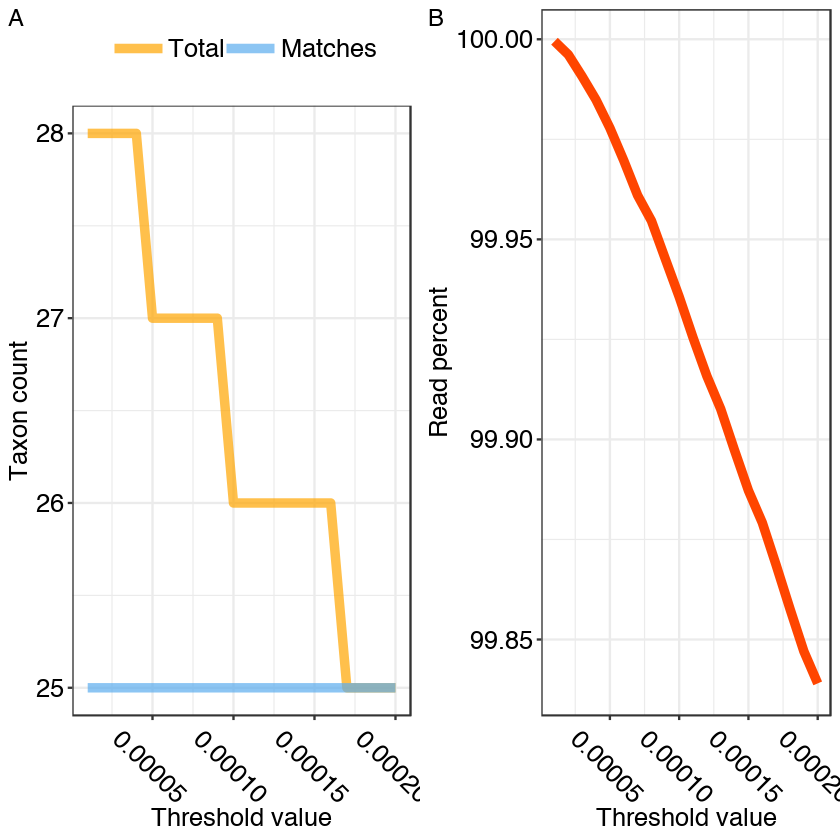

In [11]:
plot.threshold(ws.threshold1)

***
OK, so the results argue that a WS threshold of 1.7e-4 yields the appropriate number of taxa in the even positive control for library 1. However, there's a good argument to be made for calling ASVs and filtering contaminants on a run specific basis (to do that, each run should be its own phyloseq object at this stage, but let's move forward to stay illustrative). To that end, let's look at one of the positive controls from the second run. <br> 


In [12]:
(ws.threshold2 <- estimate.WSthreshold(ps = e3, WSrange = c(1e-5:7e-4, 1e-5), controlID = "377", controlFASTA = mock.fasta))


Estimating filtering statistics from WS thresholds 1e-05 to 7e-04 by 1e-05


threshold.value,control.taxa.count,control.taxa.matches,read.count,read.percent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00001,32,25,13698507,99.99951
0.00002,32,25,13698047,99.99615
0.00003,29,25,13697298,99.99069
0.00004,29,25,13696500,99.98486
0.00005,29,25,13695537,99.97783
0.00006,29,25,13694424,99.96970
0.00007,29,25,13693231,99.96100
0.00008,28,25,13692359,99.95463
0.00009,28,25,13691054,99.94510


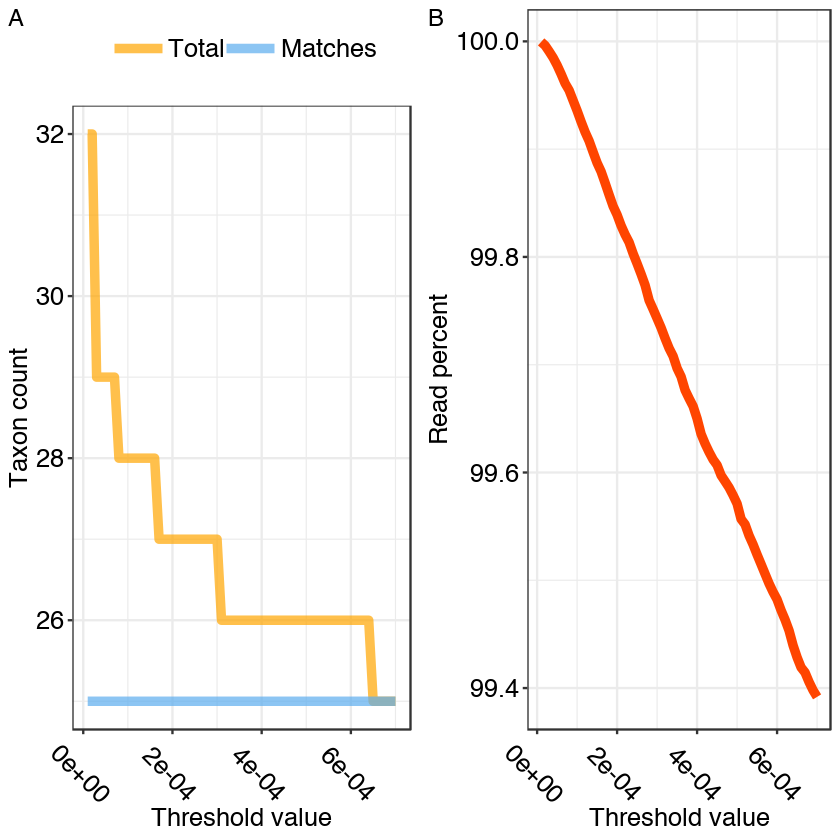

In [13]:
plot.threshold(ws.threshold2)


***
As expected, our thresholds vary a bit between runs. For library two, the results suggest that a WS threshold of 6.5e-4 is sufficient to clean up the even positive control for that run. Despite this ~4-fold difference in threshold values between runs, this discrepancy is actually rather trivial, likely only affecting within-sample ASV thresholds by a few reads (eg. for a sample with 10,000 reads, the minimum number that an ASV would need to be retained would be increased by ~ 4 reads), so we're in pretty good shape. 

Because these values are so similar, we'll press forward as-is. However, for larger discrepancies, it's probably best to filter on a run-specific basis. Now that we've determined our WS threshold (6.5e-4), let's estimate our AS filter thresholds with this value as a fixed parameter. There are several global, AS filtering strategies for removing exogenous contaminants from marker gene datasets. Here, we focus on three popular approaches that can all be estimated and applied using the suite of functions sourced above. <br>
<br>


<a id="estimate.ASthreshold"></a>
# estimate.ASthreshold
<div class="alert alert-block alert-info">
<b>ESTIMATE.ASTHRESHOLD</b><br>
Performs AS filter threshold estimation by iterative application over a range of threshold values and filtering strategies. Supports the (optional) application of fixed thresholds if you want to optimize one or multiple threshold with the other(s) fixed. <br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset.<br>
<br>
<b>Parameters (all are optional):</b><br>
<b>WST:</b> The WS threshold to apply before estimation of AS thresholds.<br>
<b>mdCAT:</b> The sample data category used in conjunction with mdFACTOR for metadata based filtering.<br>
<b>mdFACTOR:</b> The factor within mdCAT used for metadata based filtering.<br>
<b>mdNEGATIVE:</b> A logical flag indicating whether metadata-based filtering should be positive (remove matching samples) or negative (remove non matching samples).<br>
<b>minLIB:</b> The minimum sequence depth for a sample to be retained.<br>
<b>RArange:</b> The range of relative abundance filter thresholds to iterate over, followed by the estimation interval. <br>
<b>CVrange:</b> The range of CV filter thresholds to iterate over, followed by the estimation interval.<br>
<b>PFrange:</b> The range of prevalence filter thresholds to iterate over, followed by the estimation interval. <br>
<b>RAT:</b> Relative Abundance Threshold; the fixed percentage of reads across the dataset for which an ASV must be present for that ASV to be retained. <br>
<b>CVT:</b> Coefficient of Variation Threshold; the fixed lowest CV value of an ASV for that ASV to be retained.<br>
<b>PFT:</b> Prevalence Filter Threshold; the fixed percentage of samples across the dataset for which an ASV must be present for that ASV to be retained. <br>

<br>
<b>Output:</b> <br>
<b>relative.abundance.filtering.stats:</b> The ASV count remaining in the dataset at the given relative abundance threshold. <br>
<b>CV.filtering.stats:</b> The ASV count remaining in the dataset at the given CV threshold. <br>
<b>prevalence.filtering.stats:</b> The ASV count remaining in the dataset at the given prevalence threshold. <br>
<b>ASV.filtering.stats:</b> A dataframe listing the read count, read percent, prevalence count, prevalence percent, CV, taxonomic ranks, and sequence identity of each ASV.<br>

</div> 


<div class="alert alert-block alert-success">
<b>TIP:</b> To manintain fidelity with the pipeline used by the <b>microfilter</b> function (and so that threshold estimation is accurate), <b>estimate.ASthreshold</b> supports WS threshold application and metadata and read count based sample filtering. That is, if you plan to remove any samples matching metadata identifiers or below a read count threshold using <b>microfilter</b>, it's best to apply those same metrics to the <b>estimate.ASthreshold</b> function for accurate threshold estimation. Samples removed prior to threshold estimation by <b>estimate.ASthreshold</b> are not permanently removed from the dataset. 
</div>
<br>
<br>
We'll use the __estimate.ASthreshold__ function to simultaneously estimate all three filter thresholds.


In [14]:
as.threshold <- estimate.ASthreshold(ps = e3, WST = 6.5e-4, minLIB = 1000, mdFACTOR = "Mock", mdCAT = "Visit", Prange = c(0.01:0.1, 0.005), CVrange = c(0:5, 0.1), 
                                     RArange = c(1e-5:1e-3, 1e-5))


Removing 27 samples with read count < 1000
Applying WS filter threshold of 0.00065
Removing 4 samples matching metadata identifiers Visit:Mock
Estimating filtering statistics from relative abundance thresholds 1e-05 to 0.001 by 1e-05
Estimating filtering statistics from CV thresholds 0 to 5 by 0.1
Estimating filtering statistics from prevalence thresholds 0.01 to 0.1 by 0.005


In [15]:
as.threshold$relative.abundance.filtering.stats[1:10,]

relative.abundance.filter,ASV.count
<dbl>,<dbl>
1e-05,532
2e-05,412
3e-05,361
4e-05,326
5e-05,306
6e-05,286
7e-05,269
8e-05,262
9e-05,253


In [16]:
as.threshold$CV.filtering.stats[1:10,]

CV.filter,ASV.count
<dbl>,<dbl>
0.0,1642
0.1,1642
0.2,1642
0.3,1642
0.4,1642
0.5,1642
0.6,1642
0.7,1642
0.8,1642


In [17]:
as.threshold$prevalence.filtering.stats[1:10,]

prevalence.filter,ASV.count
<dbl>,<int>
0.010,298
0.015,220
0.020,196
0.025,168
0.030,146
0.035,125
0.040,118
0.045,111
0.050,109


In [18]:
as.threshold$ASV.filtering.stats[1:10,]

ASV.read.count,ASV.read.percent,ASV.prevalence,ASV.prevalence.percent,ASV.CV,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASV.ID
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
2821241,20.734208,307,87.464387,1.137142,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,iners,TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTGGTGAAGAAGGACAGGGGTAGTAACTGACCTTTGTTTGACGGTAATCAATTAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGTGCAGGCGGCTCGATAAGTCTGATGTGAAAGCCTTCGGCTCAACCGGAGAATTGCATCAGAAACTGTCGAGCTTGAGTACAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCGGTGGCGAAGGCGGCTCTCTGGTCTGTTACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACAGG
1163923,8.554044,140,39.886040,2.368573,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NA,NA,TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCGTGAGCGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGAAGGGAAGAAAATGACGGTACCTTACTAAGAAGCTCCGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGTGTAGGCGGCACTATAAGTCTGATGTGAAAACCTAAGGCTTAACCATAGGATTGCATTGGAAACTGTAGAGCTGGAGTATCGGAGAGGCAAGCGGAATTCCTGGTGTAGTGGTGAAATACGTAGATATCAGGAAGAACATCGGTGGCGAAGGCGGCTTGCTGGACGATAACTGACGCTAAGGCTCGAAAGCGTGGGAAGCGAACAGG
803447,5.904790,94,26.780627,3.209890,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,acidophilus/casei/crispatus/gallinarum,TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTTGGTGAAGAAGGATAGAGGTAGTAACTGGCCTTTATTTGACGGTAATCAACCAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGAAGAATAAGTCTGATGTGAAAGCCCTCGGCTTAACCGAGGAACTGCATCGGAAACTGTTTTTCTTGAGTGCAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACAGG
603155,4.432780,107,30.484330,2.535069,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,NA,TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTGGTGAAGAAGGACAGGGGTAGTAACTGACCTTTGTTTGACGGTAATCAATTAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGTGCAGGCGGTTCGATAAGTCTGATGTGAAAGCCTTCGGCTCAACCGGAGAATTGCATCAGAAACTGTCGAGCTTGAGTACAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCGGTGGCGAAGGCGGCTCTCTGGTCTGTTACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACAGG
502779,3.695085,126,35.897436,2.550646,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Gardnerella,vaginalis,TGGGGAATATTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCGTGCGGGATGAAGGCCTTCGGGTTGTAAACCGCTTTTGATTGGGAGCAAGCTTTCGGGTGAGTGTACCTTTCGAATAAGCGCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTCGTCGCGTCTGGTGTGAAAGCCCATCGCTTAACGGTGGGTCTGCGCCGGGTACGGGCGGGCTAGAGTGCAGTAGGGGAGACTGGAATTCCCGGTGTAACGGTGGAATGTGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGGTCTCTGGGCTGTTACTGACGCTGAGAAGCGAAAGCGTGGGGAGCGAACAGG
444239,3.264855,158,45.014245,1.806534,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Veillonellaceae,Megasphaera,NA,TGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATTGTAAAGCTCTGTTATACGGGACGAAAAAGACGGATGCCAACAGTATCCGTCCGTGACGGTACCGTAAGAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGCAGGCGGTTCGGTAAGTCTGTCTTAAAAGTGCGGGGCTTAACCCCGTGAGGGGACGGAAACTGTCGAACTTGAGTGTCGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTTTCTGGACGACAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG
261842,1.924361,4,1.139601,11.256905,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,mutans,TAGGGAATCTTCGGCAATGGACGAAAGTCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTAAGTCAAGAACGTGTGTGAGAGTGGAAAGTTCACACAGTGACGGTAGCTTACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGGGAGCGCAGGCGGTCAGGAAAGTCTGGAGTAAAAGGCTATGGCTCAACCATAGTGTGCTCTGGAAACTGTCTGACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAAGCGGCT

We'll use the same plotting function as above, __plot.threshold__, to visualize the effects of multiple AS filter thresholds on the ASV count across the dataset. 

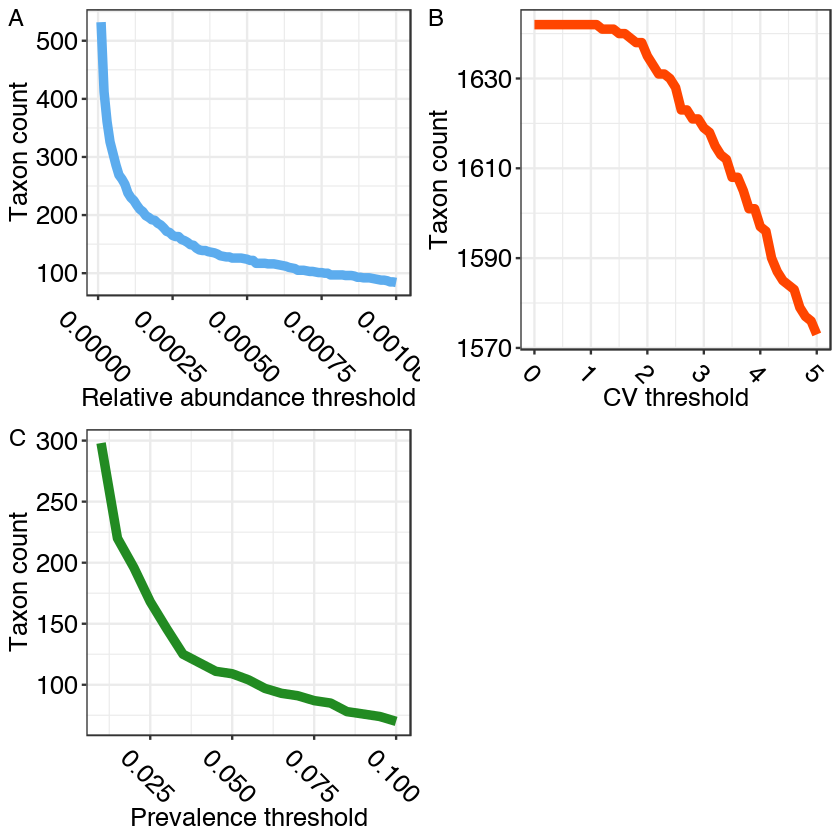

In [19]:
plot.threshold(as.threshold)

Generally, I choose AS filter thresholds by examining the values around when the taxonomic curves begin to become asymptotic. Filtering at those values should remove most low abundance, low prevalence taxa (which we can't do too much with, statistically) and/or minor contaminants or stochastic associates. <b> With that said, each dataset looks different and hopefully these tools can help guide you to a logical solution. </b> <br>
<br>

Now that we've taken a peek at the effect of multiple thresholds and filters on the dataset ASV counts, let's see how these filters will affect the taxonomic profile of our ASVs. We can again use __plot.threshold__ to visualize these effects. For this purpose, we'll have to specify a few extra parameters, as illustrated below. For each plot, either a solid (x-axis variable) or dashed (y-axis variable) black line indicates the assocaited filter threshold chosen. __Taxa that would remain after filtering exist in the space above and right of the horizontal and vertical lines, respectively.__ <br>

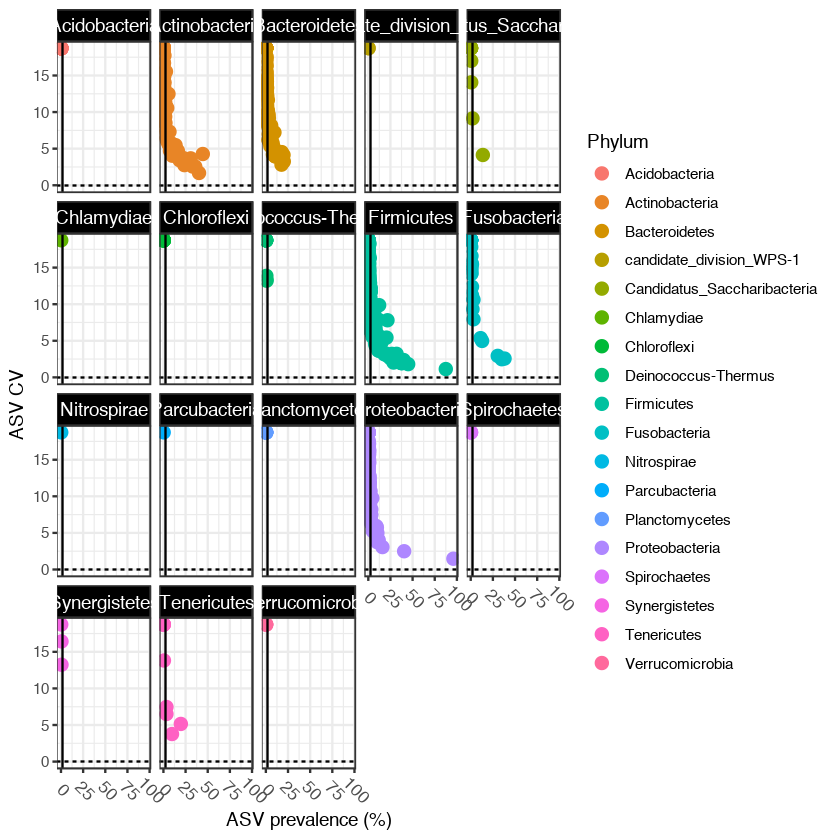

In [20]:
plot.threshold(est.obj = as.threshold, x= "P", y= "CV", taxrank = "Phylum", PFT = 2, CVT = 0)


Because __plot.threshold__ returns a ggplot2-class object, we can modify it to accomodate various graphical modifications. In the above figure, the number of phyla results in truncated facet labels. Let's modify our next plots to be a little more readable by moving our legend and reducing the font size of our facet labels.

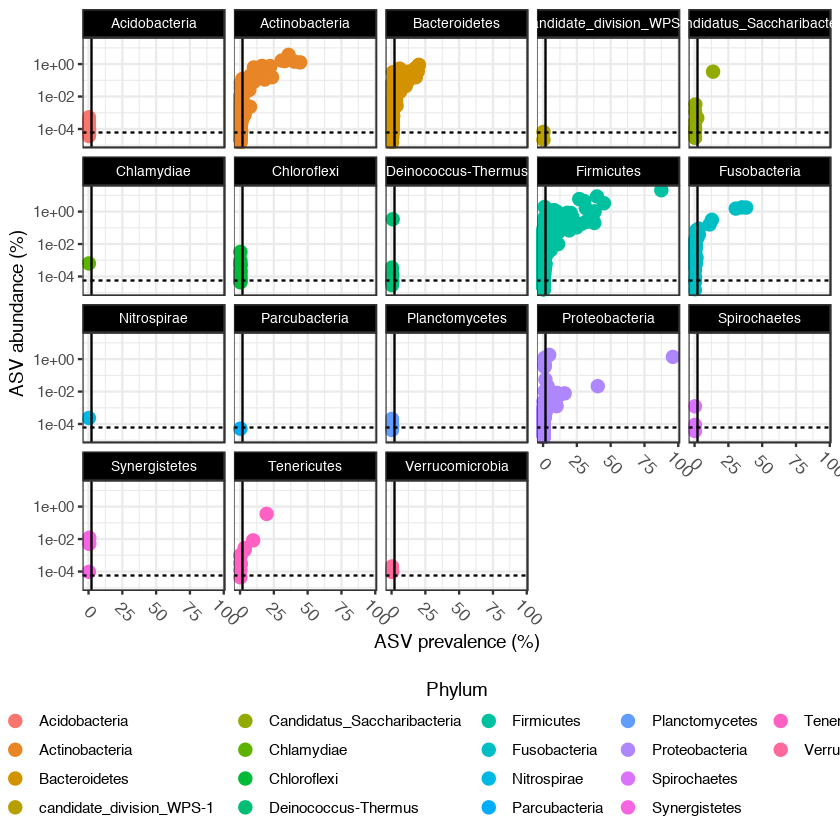

In [21]:
p2 <- plot.threshold(est.obj = as.threshold, x= "P", y= "RA", taxrank = "Phylum", PFT = 2, RAT = 6e-5)

p2 + ggplot2::theme(legend.position = "bottom",
                         strip.text = element_text(size=8, color="white")) + 
ggplot2::guides(color=guide_legend(title.position = "top", title.hjust = 0.5))

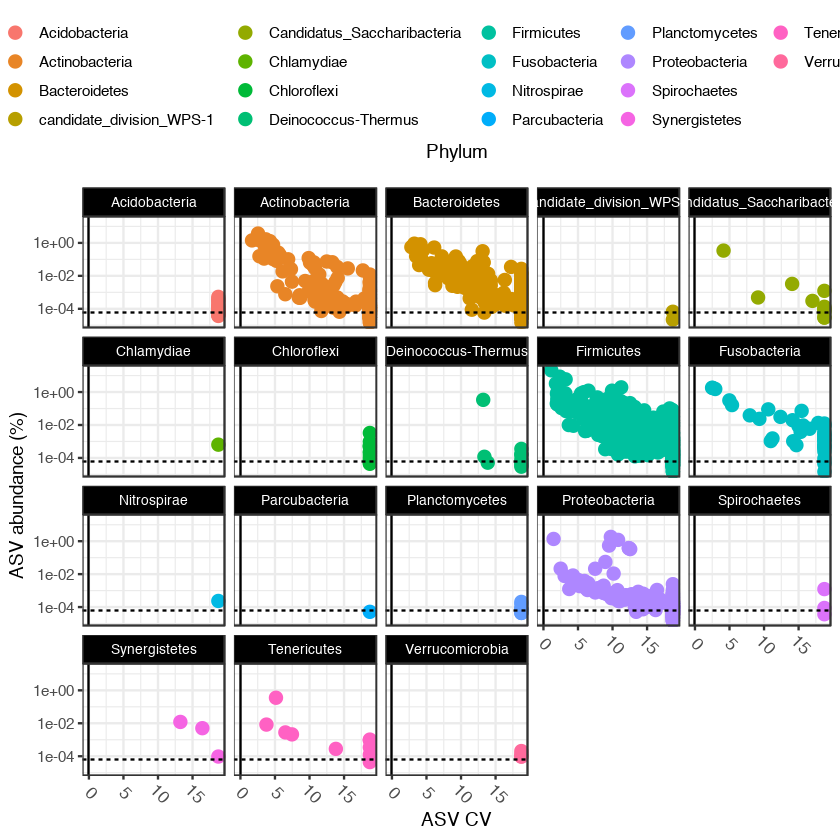

In [22]:
p3 <- plot.threshold(est.obj = as.threshold, x= "CV", y= "RA", taxrank = "Phylum", CVT = 0, RAT = 6e-5)

p3 + ggplot2::theme(legend.position = "top",
                         strip.text = element_text(size=8, color="white")) + 
ggplot2::guides(color=guide_legend(title.position = "bottom", title.hjust = 0.5))


<div class="alert alert-block alert-warning">
<b>Commentary:</b> You might notice that I only chose to apply relative abundance and prevalence filters. 
While I think that all three have their associated merits, CV calculations and filters are particularly 
susceptible to compositional effects. <b>Prior to estimation and application of CV parameters, estimate.ASthreshold normalizes each sample to the median sequencing depth of the dataset, but this still does not properly account 
for the compositional nature of marker gene studies.</b> <i>With that said, you should feel free to apply 
whatever approaches that you feel are appropriate!</i>
</div>

<a id="filter.dataset"></a>
# microfilter
<div class="alert alert-block alert-info">
<b>MICROFILTER</b><br>
A highly flexible function capable of applying any combination of WS and AS (relative abundance, prevalence, CV) taxonomic filters, as well as metadata (positive and negative) and read count based sample filters. <br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset.<br>
<br>
<b>Parameters (all are optional):</b><br>
<b>controlID:</b> As above, used only for reporting ASV read count, taxonomy, and sequence identity of taxa in the positive control.<br>
<b>mdCAT:</b> The sample data category used in conjunction with mdFACTOR for metadata based filtering.<br>
<b>mdFACTOR:</b> The factor within mdCAT used for metadata based filtering.<br>
<b>mdNEGATIVE:</b> A logical flag indicating whether metadata-based filtering should be positive (remove matching samples) or negative (remove non matching samples).<br>
<b>minLIB:</b> The minimum sequence depth for a sample to be retained.<br>
<b>RAT:</b> Relative Abundance Threshold; the percentage of reads across the dataset for which an ASV must be present for that ASV to be retained. <br>
<b>CVT:</b> Coefficient of Variation Threshold; the lowest CV value of an ASV for that ASV to be retained.<br>
<b>PFT:</b> Prevalence Filter Threshold; the percentage of samples across the dataset for which an ASV must be present for that ASV to be retained. <br>
<b>return.all:</b> A logical flag indicating whether to return all output or only the filtered dataset. Default is FALSE.<br>
<br><br>
<b>Output:</b> <br>
<b>control.taxa.sequences</b>
-  These are the nucleotide sequences of the taxa remaining in the positive control after applying the within-sample filter threshold. Useful for cross referenceing annotations against additional databases.<br>
<b>taxonomy.of.control.taxa</b>
-   The taxonomy of taxa in the positive control are output in the same order as the sequences, above. Generally useful for validating that the bugs detected in your mock community are as intended. <br>
<b>read.count.table</b>
-  This table lists the read count and percentage remaining after each filtering step. Samples matching given metadata identifiers are removed after application of the WS filter and prior to the AS filter(s) and, as such, will list NA values for AS filter statistics.  <br>
<b>relative abundance.filter.threshold</b>
-  The read count corresponding to the percentage given to the RAT parameter. <br>
<b>prevalence.filter.threshold</b>
-  The sample count corresponding to the percentage given to the PFT parameter. <br>
<b>filtered.phyloseq</b>
-  the shiny new (phyloseq class) filtered dataset with control samples removed. <br>

</div>


Now that we've estimated our WS and AS filtering thresholds, we can apply these thresholds to our dataset with the __microfilter__ function. Due to the multifacted nature of the function, we'll also simultaneously remove samples with less than 1000 reads and those that are flagged as controls by metadata identifiers. 

In [23]:
e3.f <- microfilter(ps = e3, WST = 6.5e-4, PFT = 0.02, RAT = 6e-5, minLIB = 1000, mdFACTOR = "Mock", mdCAT = "Visit", controlID = "185", return.all = TRUE)

Removing 27 samples with read count < 1000
Applying WS filter threshold of 0.00065
Removing 4 samples matching metadata identifiers Visit:Mock
Applying relative abundance threshold of 6e-05
Applying prevalence threshold of 0.02


In [24]:
e3.f$ntaxa.in.control

[1] 25

In [25]:
e3.f$control.taxa.sequences

[1] "TAGGGAATCTTCGGCAATGGACGAAAGTCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTAAGTCAAGAACGTGTGTGAGAGTGGAAAGTTCACACAGTGACGGTAGCTTACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGGGAGCGCAGGCGGTCAGGAAAGTCTGGAGTAAAAGGCTATGGCTCAACCATAGTGTGCTCTGGAAACTGTCTGACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAAGCGGCTCTCTGGTCTGTCACTGACGCTGAGGCTCGAAAGCGTGGGTAGCGAACAGG" 
 [2] "TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGCGTGTATGAAGAAGGCCTTCGGGTTGTAAAGTACTTTCAGCGGGGAGGAAGGGAGTAAAGTTAATACCTTTGCTCATTGACGTTACCCGCAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG" 
 [3] "TAGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGATGAAGGTCTTCGGATCGTAAAACTCTGTTATTAGGGAAGAACAAATGTGTAAGTAACTATGCACGTCTTGACGGTACCTAATCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGAAAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCATGTGTAGCGGTGAAATGCGCAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACGCTGATGTGCGAAAGCGTGGGGATCAAACAGG" 
 [4] "TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGGTAGTGAAGAAAGATAGAGGTAGTAACTGGCCTTTATTTGACGGTAATTACTTAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGTGCAGGCGGTTCAATAAGTCTGATGTGAAAGCCTTCGGCTCAACCGGAGAATTGCATCAGAAACTGTTGAACTTGAGTGCAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACAGG" 
 [5] "TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGCGTGATCGATGAAGGCCTTAGGGTTGTAAAGATCTTTCAGGTGGGAAGATAATGACGGTACCACCAGAAGAAGCCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGGGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATCGGAAAGTCAGAGGTGAAATCCCAGGGCTCAACCCTGGAACTGCCTTTGAAACTCCCGATCTTGAGGTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG"                          
 [6] "TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGTGTGAAGAAGGTCTTCGGATTGTAAAGCACTTTAAGTTGGGAGGAAGGGCAGTAAGTTAATACCTTGCTGTTTTGACGTTACCAACAGAATAAGCACCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG" 
 [7] "TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCGCGTGAGTGATGACGGTCTTCGGATTGTAAAGCTCTGTCTTCAGGGACGATAATGACGGTACCTGAGGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGTGGATATTTAAGTGGGATGTGAAATACTCGGGCTTAACCTGGGTGCTGCATTCCAAACTGGATATCTAGAGTGCAGGAGAGGAAAGTAGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAATACCAGTGGCGAAGGCGACTTTCTGGACTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAACAGG"                          
 [8] "TAGGGAATCTTCGGCAATGGACGGAAGTCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTTAGAGAAGAACGTTGGTAGGAGTGGAAAATCTACCAAGTGACGGTAACTAACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTCTTTAAGTCTGAAGTTAAAGGCAGTGGCTTAACCATTGTACGCTTTGGAAACTGGAGGACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG" 
 [9] "TAGGGAATATTGCTCAATGGGGGAAACCCTGAAGCAGCAACGCCGCGTGGAGGATGAAGGTTTTAGGATTGTAAACTCCTTTTGTTAGAGAAGATAATGACGGTATCTAACGAATAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGCGTAGGCGGGATAGTCAGTCAGGTGTGAAATCCTATGGCTTAACCATAGAACTGCATTTGAAACTACTATTCTAGAGTGTGGGAGAGGTAGGTGGAATTCTTGGTGTAGGGGTAAAATCCGTAGAGATCAAGAGGAATACTCATTGCGAAGGCGACCTGCTGGAACATTACTGACGCTGATTGCGCGAAAGCGTGGGGAGCAAACAGG"                         
[10] "TGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTCTG

In [26]:
e3.f$taxonomy.of.control.taxa

Kingdom,Phylum,Class,Order,Family,Genus,Species
Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,mutans
Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia/Shigella,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,gasseri/johnsonii
Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobacter,johrii/megalophilus/ovatus/sphaeroides
Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,NA
Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Clostridium_sensu_stricto,NA
Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,agalactiae/dysgalactiae
Bacteria,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Helicobacteraceae,Helicobacter,pylori
Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,meningitidis


In [27]:
e3.f$read.count.table[135:149, ]

,unfiltered.read.count,WSfiltered.read.count,WSfiltered.read.percent,ASfiltered.read.count,ASfiltered.read.percent
233,104899,104075,99.21448,103715,98.87130
234,182190,180268,98.94506,177580,97.46967
235,19112,19057,99.71222,18655,97.60883
236,41766,41375,99.06383,39988,95.74295
237,37673,37216,98.78693,15648,41.53638
238,10183,10163,99.80359,9491,93.20436
239,2388,2388,100.00000,2339,97.94807
24,1861,1861,100.00000,1841,98.92531
240,14054,14018,99.74385,13715,97.58788
241,19769,19709,99.69649,19007,96.14548


In [28]:
e3.f$relative.abundance.filter.read.count

[1] 719.9105

In [29]:
e3.f$prevalence.filter.sample.count

[1] 6.94

In [30]:
(e3f <- e3.f$filtered.phyloseq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 152 taxa and 347 samples ]
sample_data() Sample Data:       [ 347 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 152 taxa by 7 taxonomic ranks ]

Hey, that looks like a pretty tidied up dataset! Let's say that we want to remove samples from a specific visit and those that tested positive for gonorrhea? __microfilter__ works great wtih standard dplyr pipe operators.

In [31]:
e3f %>%
  microfilter(mdFACTOR = "1.1", mdCAT = "Visit") %>%
  microfilter(mdFACTOR = "gnc", mdCAT = "Site") -> e3f.noghon

Removing 28 samples matching metadata identifiers Visit:1.1
Removing 3 samples matching metadata identifiers Site:gnc


Finally, let's subset our filtered dataset to include only samples that were collected during the first week of the study. We can enable negative metadata filtering via the __microfilter__ function with the flag mdNEGATIVE.

In [32]:
E3F <- microfilter(ps = e3f.noghon, mdCAT = "Visit", mdFACTOR = "0", mdNEGATIVE = TRUE, return.all = FALSE)

Removing 133 samples not matching metadata identifiers Visit:0


In [33]:
E3F

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 152 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 152 taxa by 7 taxonomic ranks ]

## Processing and exporting
<br>Now that we've filtered the dataset to our liking, we'll export all of the data associated with our final, filtered dataset using the __write.dataset__ function. Unfortunately, I've never been able to get the biomformat package (v1.8.0) to play nice with my datasets. In case the kinks get worked out, I'd recommend using the __write.dataset.biom__ function to export your dataset directly to biom format. Until then, we'll use __write.dataset__ to perform some final minor modifications and export our dataset. 

<a id="write.dataset"></a>
# write.dataset, write.dataset.biom
<div class="alert alert-block alert-info">
<b>WRITE.DATASET, WRITE.DATASET.BIOM</b><br>
Exporting functions for writing marker gene datasets to external files.<br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset.<br>
<br>
<b>Parameters:</b><br>
<b>filePATH:</b> The filepath where output should be written.<br>
<b>filePREFIX:</b> The prefix identifier for all output written.<br>
<b>writeFASTA:</b> A logical flag indicating if ASV sequences should be written to an external FASTA file. Generally, a good idea, but can be time consuming if 1000s of taxa remain in your dataset when writing. Default is TRUE.<br>
<b>rename:</b> A logical flag indicating if ASV identifiers should be renamed to ASV1, ASV2, ..., ASVN. Default is FALSE.<br>
<br>
<b>Output:</b> <br>
<b>_ASVs.fasta:</b>  FASTA of all ASV sequences. Even if rename=FALSE, FASTA identifiers are labeled ASV1, ASV2,... <br>
<br>
<b>write.dataset.biom:</b><br>
<b>_ASV_table.biom:</b> A biom file with observation and sample metadata integrated. I've run into problems attempting to import the resulting biom back into phyloseq, but this might warrant a closer look with a newer version. <br>
<br>
<b>write.dataset:</b><br>
<b>_ASV_table.txt:</b>  A standard count table (eg. OTU table) of read counts of taxa (ASVs) across all samples. <br>
<b>_ASV_taxonomy.txt:</b> A taxonomy table with the sequence identifier (eg. ASV1) in the first column and semicolon-separated taxonomy in the second column.<br>
<b>_sample_data.txt:</b> A sample data table of all associated metadata. 
<br>

</div>
<br>
<div class="alert alert-block alert-success">
<b>TIP:</b> Before writing, all files written by <b>write.dataset</b> are formatted for easy merging into a biom file using the  <A HREF = "http://biom-format.org/documentation/biom_conversion.html">standalone biom package</A> without any further manipulation. 
</div>

Now, we'll use <b>write.dataset</b> to write the desired data to external files in the location specified and, because we've flagged the function to rename the ASVs in the dataset, we'll specify a new R object that will be identical to the previous phyloseq dataset, but with the ASVs renamed. Otherwise, we could just run the function without defining a new object.

In [34]:
fp <- paste(getwd(), "/", sep = "")
e3f.f <- write.dataset(ps = e3f, filePATH = fp, filePREFIX = "e3.f", writeFASTA=TRUE, rename = TRUE)

[1] "/Users/bpb/Desktop/microfiltR/microfiltR_vignette/e3.f_ASVs.fasta"
[1] "/Users/bpb/Desktop/microfiltR/microfiltR_vignette/e3.f_ASV_table.txt"
[1] "/Users/bpb/Desktop/microfiltR/microfiltR_vignette/e3.f_ASV_taxonomy.txt"
[1] "/Users/bpb/Desktop/microfiltR/microfiltR_vignette/e3.f_sample_data.txt"


Boom! We've now written all of the metadata associated with our filtered marker gene study to various output files. Now, let's take a final peek at our ASV count table in a format that's a little more friendly on the eyes. 

In [35]:
phyloseq::otu_table(e3f.f)[1:10, 1:10]

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10
1,16,0,0,0,160,0,0,0,685,0
10,0,244,0,0,536,48,0,0,0,162
100,251,31618,0,0,0,0,705,0,396,0
101,15722,0,6603,0,0,0,0,0,0,0
102,1993,0,0,0,58,39,0,0,0,0
103,81,0,0,0,0,169,0,0,0,103
104,326,0,18871,0,0,0,0,0,0,0
106,11,0,500,0,0,0,4,0,0,0
107,38,0,0,0,343,0,60,76,0,0
108,8064,125,0,1095,457,1378,530,239,0,846
